In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, cdist

In [7]:
#DLEDMD
import tensorflow as tf
import DLEDMD

In [8]:
#MSE and NSE
def MSE(x,y):
    return np.sqrt(np.mean(np.square(x-y)))

def NSE(pre,tar):
    a=np.sum(np.square(pre-tar))/np.sum(np.square(tar-np.mean(tar)))
    return 1-a

In [9]:
def Pre_data():
    #Prepare training data (set0)
    df_s0 = pd.read_excel(r'./save_data/excelfile/rain0_set0_state_data.xlsx')
    df_a0= pd.read_excel(r'./save_data/excelfile/rain0_set0_action_data.xlsx')
    df_r0= pd.read_excel(r'./save_data/excelfile/rain0_set0_rain_data.xlsx')
    dt_s0=df_s0.values[:1,1:]
    dt_a0=df_a0.values[:1,1:]
    dt_r0=df_r0.values[:1,1:]
    
    data=np.concatenate((dt_s0,dt_a0,dt_r0),axis=1)
    for it in [0,2,4,6,8,9]:
        for jt in [0,1,2]:   
            df_s0 = pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_state_data.xlsx')
            df_a0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_action_data.xlsx')
            df_r0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_rain_data.xlsx')
            dt_s0=df_s0.values[:,1:]
            dt_a0=df_a0.values[:,1:]
            dt_r0=df_r0.values[:,1:]
            tem=np.concatenate((dt_s0,dt_a0,dt_r0),axis=1)
            data=np.concatenate((data,tem),axis=0)
    
    data=data[1:,:]
            
    #Prepare test1 data
    df_s0 = pd.read_excel(r'./save_data/excelfile/rain0_set1_state_data.xlsx')
    df_a0= pd.read_excel(r'./save_data/excelfile/rain0_set1_action_data.xlsx')
    df_r0= pd.read_excel(r'./save_data/excelfile/rain0_set1_rain_data.xlsx')
    dt_s0=df_s0.values[:,1:]
    dt_a0=df_a0.values[:,1:]
    dt_r0=df_r0.values[:,1:]
    data_test1=[]
    data_test1.append(np.concatenate((dt_s0,dt_a0,dt_r0),axis=1))
    for it in [3,5,7]:
        for jt in [1]:   
            df_s0 = pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_state_data.xlsx')
            df_a0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_action_data.xlsx')
            df_r0= pd.read_excel(r'./save_data/excelfile/rain'+str(it)+'_set'+str(jt)+'_rain_data.xlsx')
            dt_s0=df_s0.values[:,1:]
            dt_a0=df_a0.values[:,1:]
            dt_r0=df_r0.values[:,1:]
            tem=np.concatenate((dt_s0,dt_a0,dt_r0),axis=1)
            data_test1.append(tem)
    
    #Prepare training data2 (set0)
    df_s0 = pd.read_excel(r'./save_data/excelfile/rain0_set0_state_data.xlsx')
    df_a0= pd.read_excel(r'./save_data/excelfile/rain0_set0_action_data.xlsx')
    df_r0= pd.read_excel(r'./save_data/excelfile/rain0_set0_rain_data.xlsx')
    dt_s0=df_s0.values[:,1:]
    dt_a0=df_a0.values[:,1:]
    dt_r0=df_r0.values[:,1:]
    
    return data,data_test1

data,data_test1=Pre_data()
print(data.shape)

(1080, 13)


# DLEDMD

In [10]:
X_train=data[:data.shape[0]-2,:4]
X_train_F=data[:data.shape[0]-2,4:]
Y_train=data[1:data.shape[0]-1,:4]

g2=tf.Graph()
with g2.as_default():
    params={}
    params['enlayers']=[[4+9,10],[10,50],[50,100],[100,100]]
    params['K']=[100,100]
    params['delayers']=[[100,100],[100,50],[50,10],[10,4]]

    params['input_layer']=4#X_train.shape[1]
    params['f_layer']=9#X_train_F.shape[1]
    params['output_layer']=4#Y_train.shape[1]
    params['lr']=0.0001


    model=DLEDMD.DLEDMD(params,X_train,Y_train,X_train_F)
    ybar=model.forward_net(model.x,model.f)
    loss=model.Loss(model.x,model.f,model.y)
    op=model.opt(loss)
    sess=tf.compat.v1.Session()
    
    #init_op = tf.compat.v1.global_variables_initializer()
    #sess.run(init_op)
    
    saver = tf.compat.v1.train.Saver()
    
    saver.restore(sess,'./emulator_model/DLEDMD_emulator_model/DLEDMD_model.ckpt')

INFO:tensorflow:Restoring parameters from ./emulator_model/DLEDMD_emulator_model/DLEDMD_model.ckpt


In [12]:
K=sess.run(model.weights['K'])

In [13]:
u,s,v=np.linalg.svd(K)

In [14]:
S,U=np.linalg.eig(K)

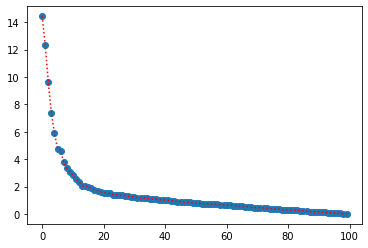

In [15]:
plt.scatter([i for i in range(s.shape[0])],s)
plt.plot(s,'r:')
plt.savefig('6.3-singular.png', bbox_inches='tight', dpi=500)   

In [16]:
eig_data=[]
for s in S:
    eig_data.append([np.real(s),np.imag(s)])

In [17]:
eig_data=np.array(eig_data)

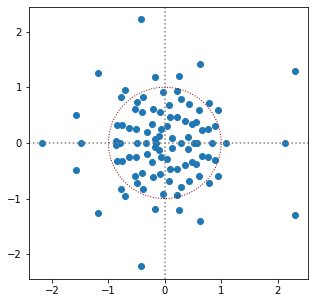

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(eig_data[:,0],eig_data[:,1])
plt.axhline(y=0,ls=":",c="grey")#添加水平直线
plt.axvline(x=0,ls=":",c="grey")#添加水平直线

theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)
y = np.sin(theta)
plt.plot(x, y, color="darkred", linewidth=1,linestyle=':')

font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}
plt.xlabel('Real',font=font1)
plt.ylabel('Image',font=font1)

plt.savefig('6.3-eigenvalues.png', bbox_inches='tight', dpi=500)   

# Draw singular fig

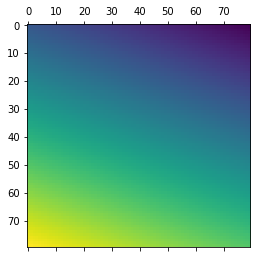

In [76]:
results=[]
for i in np.arange(-2,2,0.05):
    line=[]
    for j in np.arange(-2,2,0.05):
        xt=[i,j]
        tem=[it for it in range(98)]
        x=np.array(xt+tem)
        #line.append(x.dot(u[1,:]))
        line.append(x.dot(v.T[80,:]))
    results.append(line)
results=np.array(results)
plt.matshow(results)

# Draw eigenfunction fig

In [22]:
U[0,:]

array([ 0.03084443-0.02943859j,  0.03084443+0.02943859j,
       -0.01744208-0.00400109j, -0.01744208+0.00400109j,
        0.06829302+0.j        , -0.02072076+0.j        ,
        0.05432959+0.02871546j,  0.05432959-0.02871546j,
       -0.02239184+0.00014948j, -0.02239184-0.00014948j,
       -0.0207311 -0.05625175j, -0.0207311 +0.05625175j,
        0.10149018+0.j        ,  0.01525105+0.0409086j ,
        0.01525105-0.0409086j ,  0.07838762+0.0116163j ,
        0.07838762-0.0116163j , -0.0143842 +0.01932554j,
       -0.0143842 -0.01932554j, -0.03830646+0.j        ,
        0.01169056+0.05930366j,  0.01169056-0.05930366j,
       -0.04734687-0.0760212j , -0.04734687+0.0760212j ,
        0.0512283 -0.03503637j,  0.0512283 +0.03503637j,
       -0.07810088-0.0055692j , -0.07810088+0.0055692j ,
        0.13121528+0.02894622j,  0.13121528-0.02894622j,
        0.02787827+0.08924153j,  0.02787827-0.08924153j,
       -0.01219286+0.03070345j, -0.01219286-0.03070345j,
        0.02372649+0.05438378j,

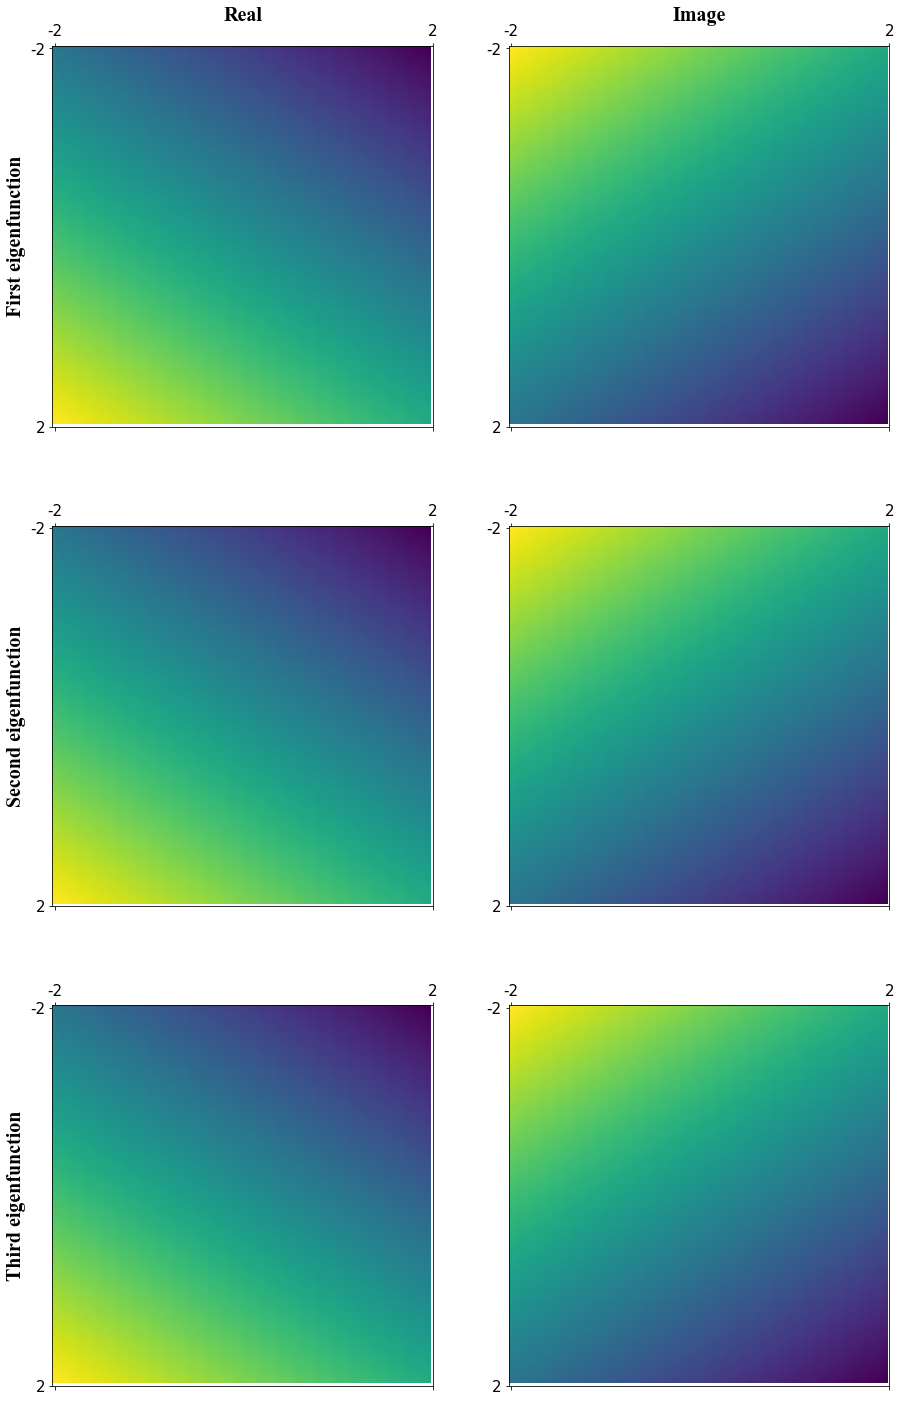

In [58]:
k=0

font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,}

font2 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 15,}


fig = plt.figure(figsize=(15,25))
it=0

names=['Real','Image']
titles=['First eigenfunction', 'Second eigenfunction','Third eigenfunction']
for j in range(3):
    for i in range(2):
        axes=fig.add_subplot(3,2,it+1)
        it=it+1
        results=[]
        for ix in np.arange(-2,2,0.05):
            line_R=[]
            for jx in np.arange(-2,2,0.05):
                xt=[ix,jx]
                tem=[0 for it in range(98)]
                x=np.array(xt+tem)
                #line.append(x.dot(u[1,:]))
                if i==0:
                    line_R.append(x.dot(U.T[k,:]).real)
                else:
                    line_R.append(x.dot(U.T[k,:]).imag)
            results.append(line_R)
        results=np.array(results)
        axes.matshow(results)
        plt.xticks([0,80],['-2','2'],fontsize=15)
        plt.yticks([0,80],['-2','2'],fontsize=15)
        if j==0:
            plt.title(names[i],fontdict=font1)
        if i==0:
            plt.ylabel(titles[j],fontdict=font1)

fig.savefig('6.3-eig_fun.png', bbox_inches='tight', dpi=500)  

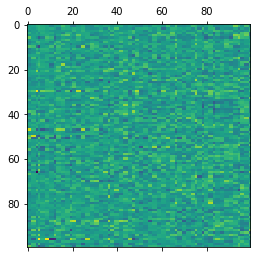

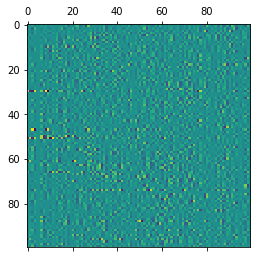

In [34]:
plt.matshow(U.real)
plt.matshow(U.imag)